In this notebook, we will analyze stock data sourced from Alpha Vantage. Our workflow will include:

   1. Feature Engineering – Creating meaningful features from raw stock data to enhance our analysis and modeling.

   2. Data Visualization – Exploring trends, patterns, and relationships in the data through visualizations.

   3. Predictive Modeling – Building a model to forecast stock behavior using the engineered features.

By the end of this notebook, we aim to uncover insights from historical stock data and demonstrate a predictive approach that can inform trading or investment decisions.

In [9]:
import requests
from dotenv import load_dotenv
from os import getenv

load_dotenv()
API_KEY = getenv("ALPHAVANTAGE_API_KEY")

symbol = "SPY"
interval = "5min"  # <-- required for TIME_SERIES_INTRADAY

url = (
    f"https://www.alphavantage.co/query"
    + "?function=TIME_SERIES_INTRADAY"
    + f"&symbol={symbol}"
    + f"&interval={interval}"  # <-- add this
    + f"&apikey={API_KEY}"
)

r = requests.get(url)
data = r.json()

In [11]:
# Print relevant metadata
print("DATA:         ", data.get("Meta Data").get("1. Information"))
print("SYMBOL:       ", data.get("Meta Data").get("2. Symbol"))
print("REFRESH DATE: ", data.get("Meta Data").get("3. Last Refreshed"))

DATA:          Intraday (5min) open, high, low, close prices and volume
SYMBOL:        SPY
REFRESH DATE:  2025-10-22 20:00:00


In [19]:
import pandas as pd

# Check if the call was successful
if "Time Series (5min)" not in data:
    print("Error fetching data:", data)
else:
    df = pd.DataFrame.from_dict(data["Time Series (5min)"], orient='index')
    df.index.name = 'date'
    df.reset_index(inplace=True)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    df['date'] = pd.to_datetime(df['date'])
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)
    df['volume'] = df['volume'].astype(int)
    df = df.sort_values('date').reset_index(drop=True)
    print(df.head())

                 date     open      high     low    close  volume
0 2025-10-22 11:45:00  668.580  669.3082  668.55  669.270  727007
1 2025-10-22 11:50:00  669.290  669.7000  669.16  669.490  615185
2 2025-10-22 11:55:00  669.530  669.7650  668.90  669.010  552522
3 2025-10-22 12:00:00  669.000  669.2000  668.10  668.405  563251
4 2025-10-22 12:05:00  668.405  668.8600  668.26  668.410  365176


In [21]:
# Convert columns to float
df['open'] = df['open'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

In [23]:
import numpy as np

df['price difference'] = df['high'] - df['low']
df.head(2)

,date,open,high,low,close,volume,price difference
0,2025-10-22 11:45:00,668.58,669.3082,668.55,669.27,727007.0,0.7582
1,2025-10-22 11:50:00,669.29,669.7000,669.16,669.49,615185.0,0.5400


In [9]:
# Sort by date just in case
df = df.sort_values('date')

# Day-to-day volume change
df['volume_change'] = df['volume'] - df['volume'].shift(1)

# Optional: percentage change
df['volume_pct_change'] = df['volume'].pct_change() * 100

# Calculate Price / Volume for each row (using Close price)
df['price by volume'] = df['close'] / df['volume']

In [10]:
# Initialize OBV
df['obv'] = 0

# Loop method with .loc
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
    elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
    else:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv']

# 7-day moving average of volume
df['volume_ma7'] = df['volume'].rolling(window=7).mean()

In [11]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns,volume_change,volume_pct_change,price by volume,obv,volume_ma7
99,2025-06-02,587.76,592.79,585.06,592.71,61630502.0,4.95,7.73,0.37,-0.005686,NaN,NaN,0.000010,1044142524,NaN
98,2025-06-03,592.34,597.08,591.85,596.09,63606204.0,3.75,5.23,-0.87,0.000268,1975702.0,3.205721,0.000009,1105773026,NaN


In [12]:
# Create lag features for close and volume
lag_days = [1, 2, 3]  # 1-day, 2-day, 3-day lags

for lag in lag_days:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    df[f'price_by_volume_lag_{lag}'] = (df['close'] * df['volume']).shift(lag)

# View result
print(df[['date', 'close', 'close_lag_1', 'close_lag_2', 'close_lag_3',
          'volume', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3']])

          date   close  close_lag_1  close_lag_2  close_lag_3       volume  \
99  2025-06-02  592.71          NaN          NaN          NaN   61630502.0   
98  2025-06-03  596.09       592.71          NaN          NaN   63606204.0   
97  2025-06-04  595.93       596.09       592.71          NaN   57314199.0   
96  2025-06-05  593.05       595.93       596.09       592.71   92436397.0   
95  2025-06-06  599.14       593.05       595.93       596.09   66588743.0   
..         ...     ...          ...          ...          ...          ...   
4   2025-10-16  660.64       665.17       662.23       663.04  110563346.0   
3   2025-10-17  664.39       660.64       665.17       662.23   96500870.0   
2   2025-10-20  671.30       664.39       660.64       665.17   60493350.0   
1   2025-10-21  671.29       671.30       664.39       660.64   56249034.0   
0   2025-10-22  667.80       671.29       671.30       664.39   80564006.0   

    volume_lag_1  volume_lag_2  volume_lag_3  
99           NaN

                      close    volume  price by volume  log returns  \
close              1.000000  0.026090         0.164685     0.151970   
volume             0.026090  1.000000        -0.917673    -0.317280   
price by volume    0.164685 -0.917673         1.000000     0.278727   
log returns        0.151970 -0.317280         0.278727     1.000000   
day to day         0.057683 -0.214580         0.146350     0.511320   
volume_change     -0.051583  0.614315        -0.544413    -0.213412   
volume_pct_change -0.022989  0.664462        -0.607051    -0.205848   
obv               -0.883342 -0.190430         0.008898    -0.080421   

                   day to day  volume_change  volume_pct_change       obv  
close                0.057683      -0.051583          -0.022989 -0.883342  
volume              -0.214580       0.614315           0.664462 -0.190430  
price by volume      0.146350      -0.544413          -0.607051  0.008898  
log returns          0.511320      -0.213412          -0

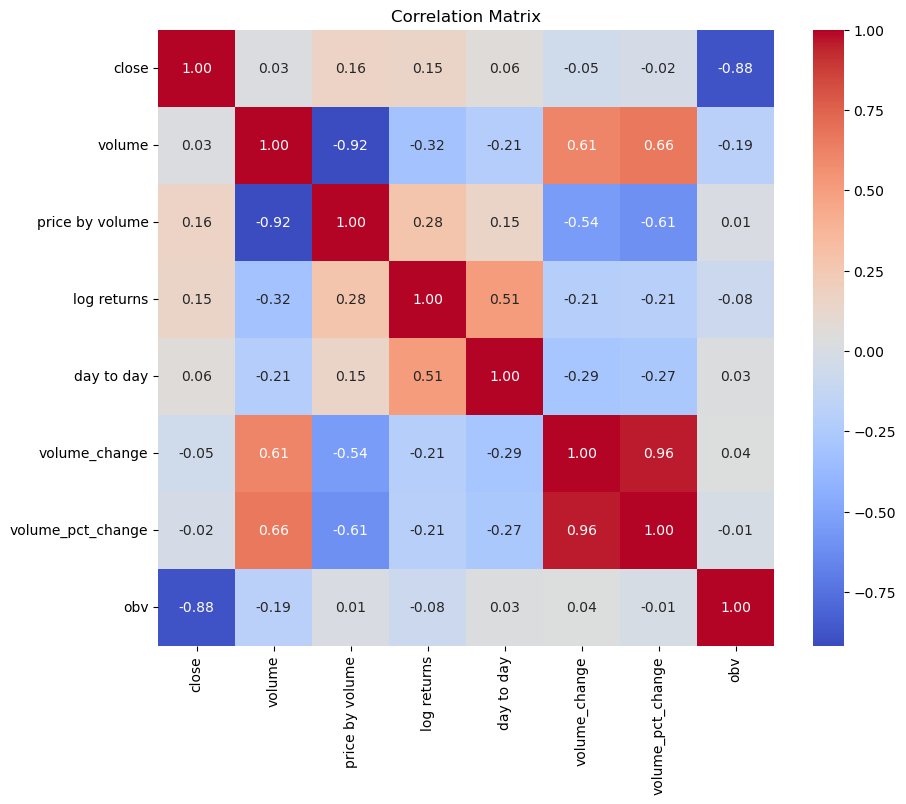

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns you want to check correlations for
numeric_cols = ['close', 'volume', 'price by volume', 'log returns', 
                'day to day', 'volume_change', 'volume_pct_change', 'obv']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

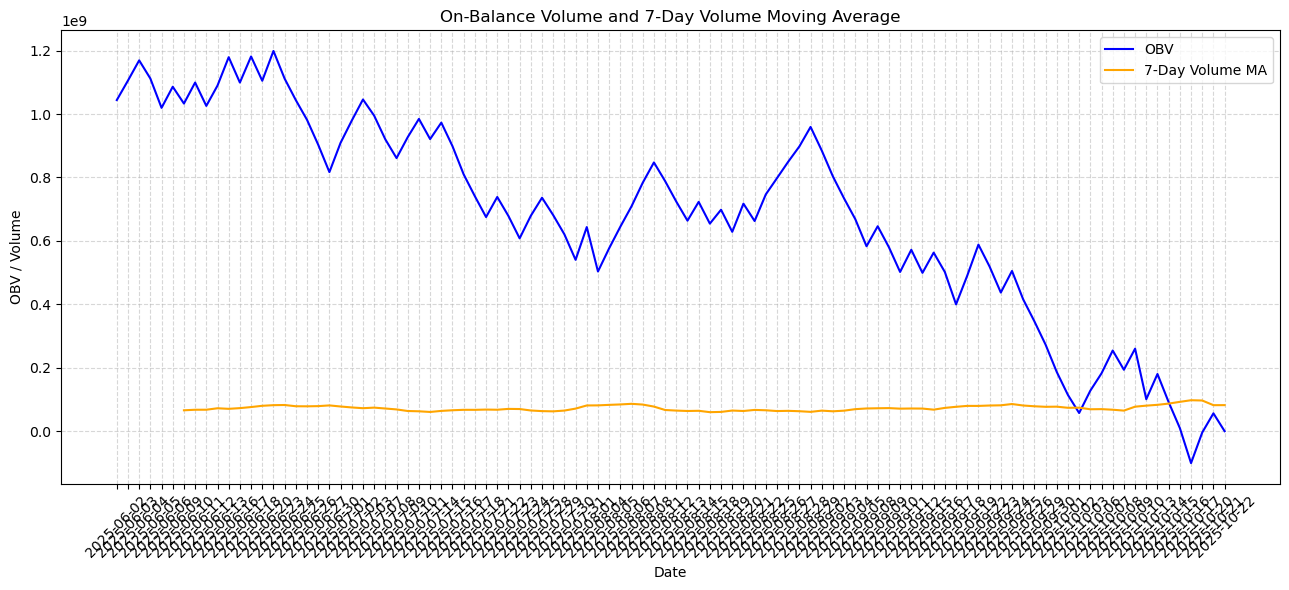

In [14]:
plt.figure(figsize=(13,6))

# OBV line
plt.plot(df['date'], df['obv'], color='blue', label='OBV')

# Volume moving average line
plt.plot(df['date'], df['volume_ma7'], color='orange', label='7-Day Volume MA')

plt.xlabel('Date')
plt.ylabel('OBV / Volume')
plt.title('On-Balance Volume and 7-Day Volume Moving Average')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

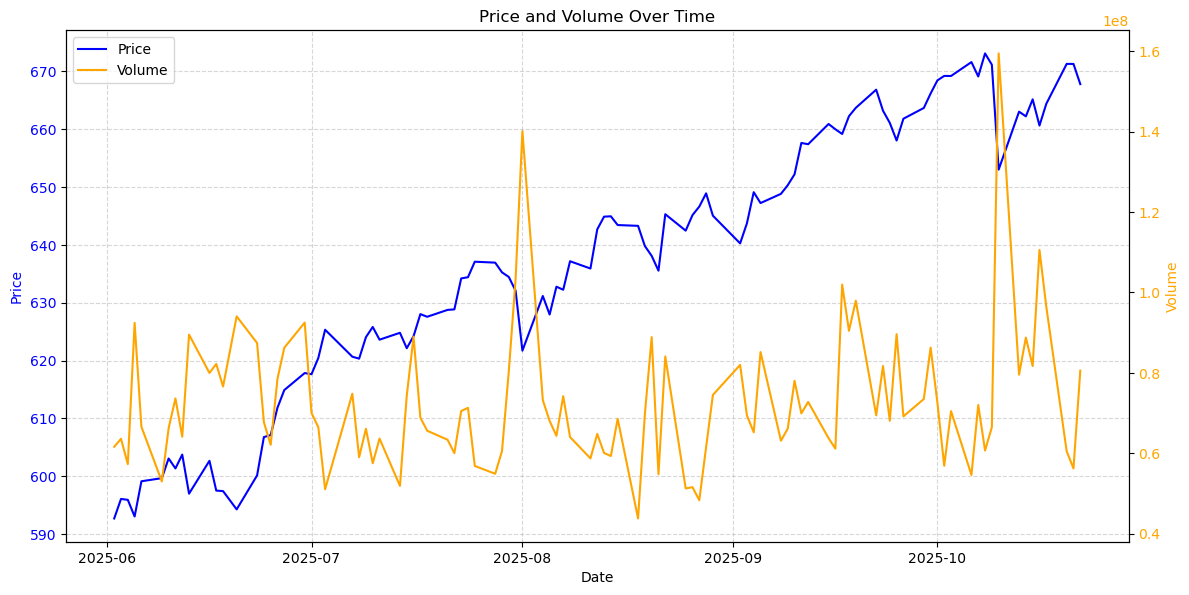

In [15]:
df['date'] = pd.to_datetime(df['date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on left Y-axis
ax1.plot(df['date'], df['close'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create second Y-axis for volume
ax2 = ax1.twinx()
ax2.plot(df['date'], df['volume'], color='orange', label='Volume')
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
fig.tight_layout()
plt.title('Price and Volume Over Time')

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

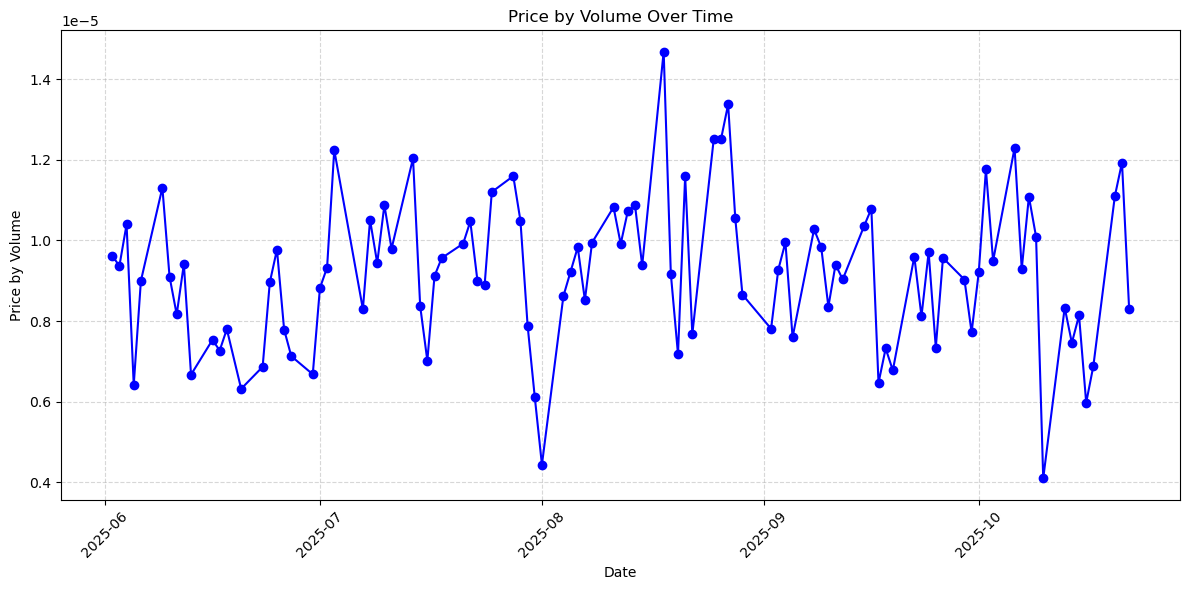

In [16]:
# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Price by Volume')
plt.title('Price by Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

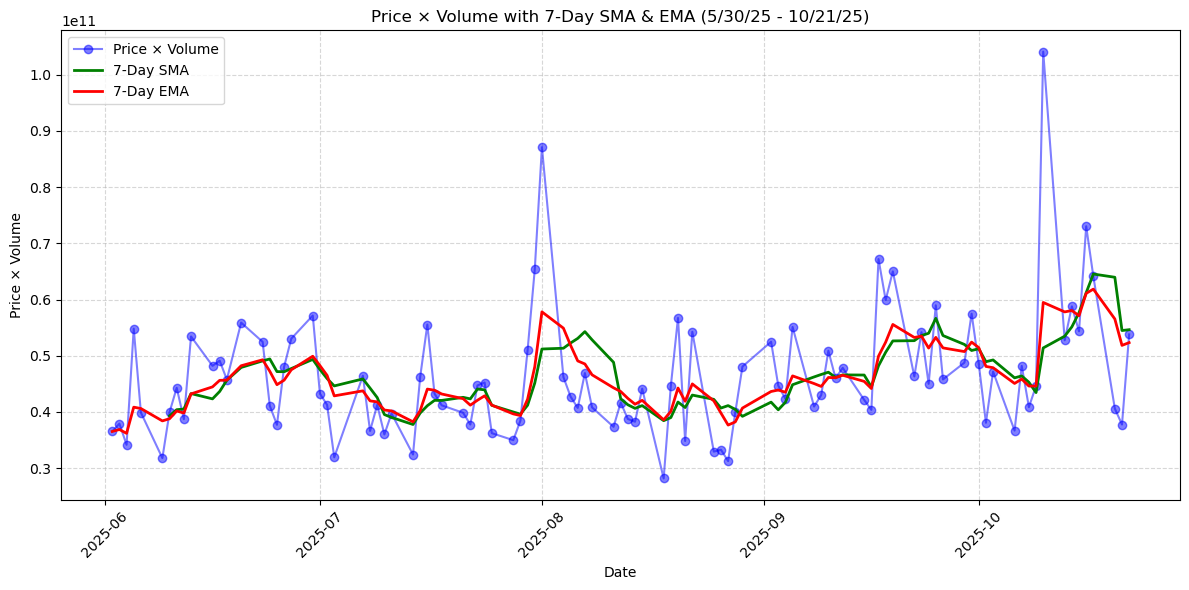

In [17]:
# Calculate Price × Volume
df['price by volume'] = df['close'] * df['volume']

# Calculate 7-day SMA
df['sma7'] = df['price by volume'].rolling(window=7).mean()

# Calculate 7-day EMA
df['ema7'] = df['price by volume'].ewm(span=7, adjust=False).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', alpha=0.5, label='Price × Volume', color='blue')
plt.plot(df['date'], df['sma7'], color='green', linewidth=2, label='7-Day SMA')
plt.plot(df['date'], df['ema7'], color='red', linewidth=2, label='7-Day EMA')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with 7-Day SMA & EMA (5/30/25 - 10/21/25)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Bullish SMA crossovers:
          date          sma7         sma30
64 2025-07-23  4.407959e+10  4.407931e+10
58 2025-07-31  4.514351e+10  4.399792e+10
33 2025-09-05  4.484316e+10  4.431543e+10
8  2025-10-10  5.138942e+10  5.036063e+10
Bearish SMA crossovers:
          date          sma7         sma30
63 2025-07-24  4.393715e+10  4.425553e+10
50 2025-08-12  4.234517e+10  4.374212e+10
12 2025-10-06  4.606819e+10  4.701435e+10
Bullish EMA crossovers:
          date          ema7         ema30
98 2025-06-03  3.687552e+10  3.661843e+10
96 2025-06-05  4.085144e+10  3.764403e+10
76 2025-07-07  4.375504e+10  4.317546e+10
69 2025-07-16  4.406927e+10  4.264159e+10
63 2025-07-24  4.287493e+10  4.246805e+10
59 2025-07-30  4.227439e+10  4.202622e+10
44 2025-08-20  4.425774e+10  4.395987e+10
42 2025-08-22  4.499088e+10  4.407347e+10
36 2025-09-02  4.364099e+10  4.289864e+10
8  2025-10-10  5.948557e+10  5.056678e+10
Bearish EMA crossovers:
          date          ema7         ema30
97 2025-06-04  3.6

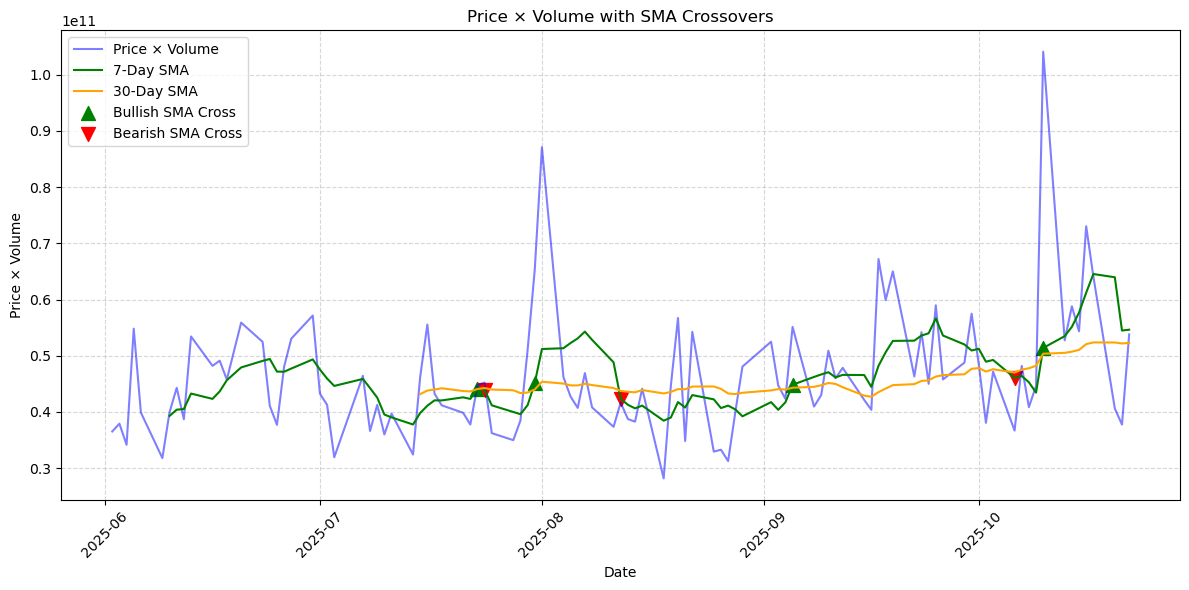

In [18]:
# Short-term and long-term SMAs
df['sma30'] = df['price by volume'].rolling(window=30).mean()

# Short-term and long-term EMAs
df['ema30'] = df['price by volume'].ewm(span=30, adjust=False).mean()

# Find crossover signals (SMA example)
df['sma_signal'] = np.where(df['sma7'] > df['sma30'], 1, 0)  # 1 = bullish, 0 = bearish
df['sma_crossover'] = df['sma_signal'].diff()  # 1 = buy, -1 = sell

# Find crossover signals (EMA example)
df['ema_signal'] = np.where(df['ema7'] > df['ema30'], 1, 0)
df['ema_crossover'] = df['ema_signal'].diff()

# Print crossover points
bullish_sma = df[df['sma_crossover'] == 1]
bearish_sma = df[df['sma_crossover'] == -1]

bullish_ema = df[df['ema_crossover'] == 1]
bearish_ema = df[df['ema_crossover'] == -1]

print("Bullish SMA crossovers:\n", bullish_sma[['date', 'sma7', 'sma30']])
print("Bearish SMA crossovers:\n", bearish_sma[['date', 'sma7', 'sma30']])
print("Bullish EMA crossovers:\n", bullish_ema[['date', 'ema7', 'ema30']])
print("Bearish EMA crossovers:\n", bearish_ema[['date', 'ema7', 'ema30']])

# Optional: plot SMA crossovers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], color='blue', alpha=0.5, label='Price × Volume')
plt.plot(df['date'], df['sma7'], color='green', label='7-Day SMA')
plt.plot(df['date'], df['sma30'], color='orange', label='30-Day SMA')

# Mark bullish and bearish crossovers
plt.scatter(bullish_sma['date'], bullish_sma['sma7'], marker='^', color='g', s=100, label='Bullish SMA Cross')
plt.scatter(bearish_sma['date'], bearish_sma['sma7'], marker='v', color='r', s=100, label='Bearish SMA Cross')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with SMA Crossovers')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

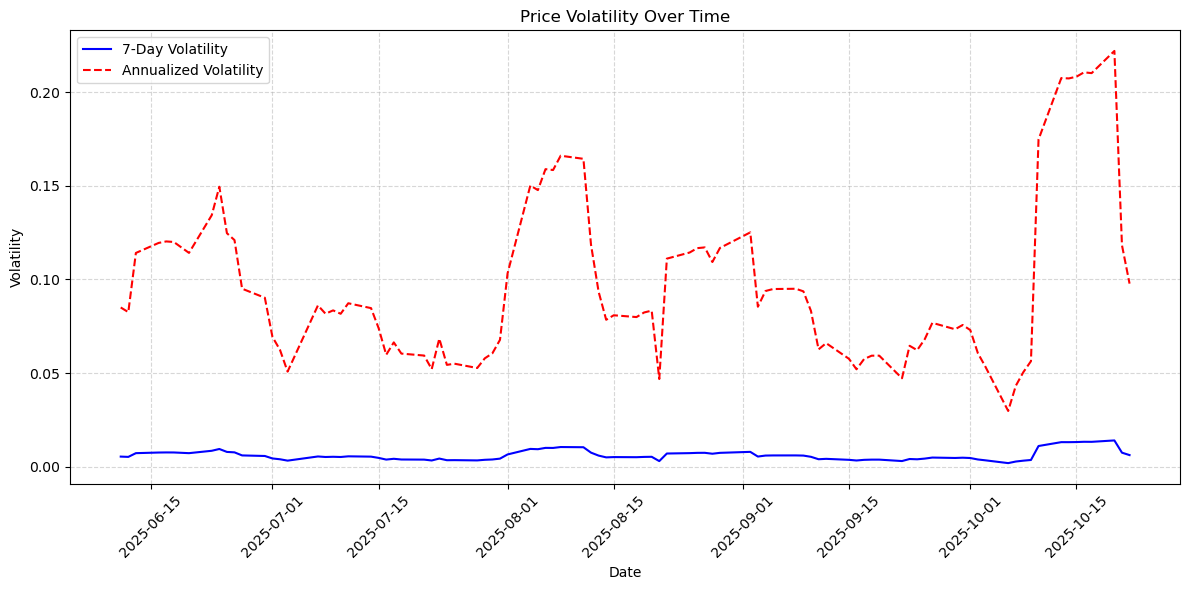

In [19]:
# Calculate daily returns
df['returns'] = df['close'].pct_change()

# Calculate rolling volatility (e.g., 7-day)
df['volatility_7d'] = df['returns'].rolling(window=7).std()

# Optional: annualized volatility (assuming 252 trading days)
df['volatility_annualized'] = df['volatility_7d'] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['volatility_7d'], label='7-Day Volatility', color='blue')
plt.plot(df['date'], df['volatility_annualized'], label='Annualized Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Price Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

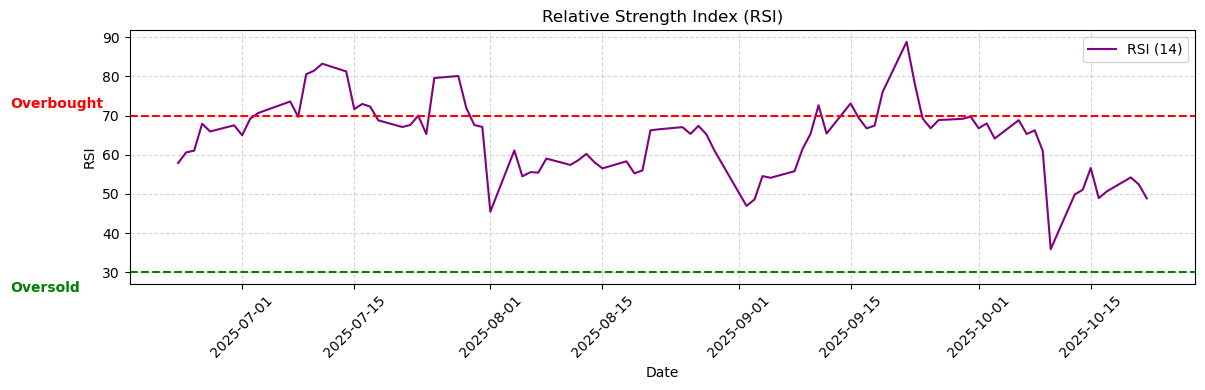

In [20]:
# Calculate daily returns
delta = df['close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate average gain/loss
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rsi'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--')  # overbought
plt.axhline(30, color='green', linestyle='--')  # oversold
plt.text(df['date'].iloc[0], 70+2, 'Overbought', color='red', fontsize=10, fontweight='bold')
plt.text(df['date'].iloc[0], 30-5, 'Oversold', color='green', fontsize=10, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

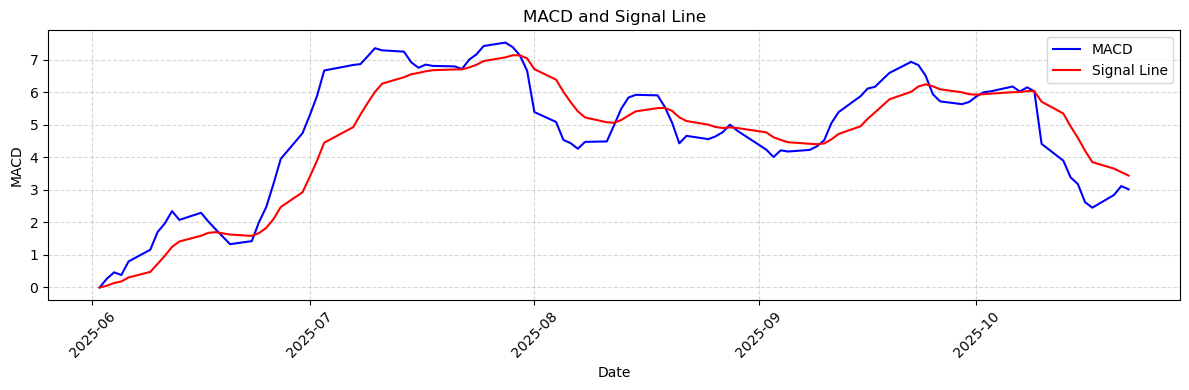

In [21]:
# Calculate MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Signal line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['macd'], label='MACD', color='blue')
plt.plot(df['date'], df['macd_signal'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD and Signal Line')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create day of week column (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Create day-of-week one-hot
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='dow')], axis=1)

# Check which columns exist
print(df.filter(like='dow_').columns)

Index(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4'], dtype='object')


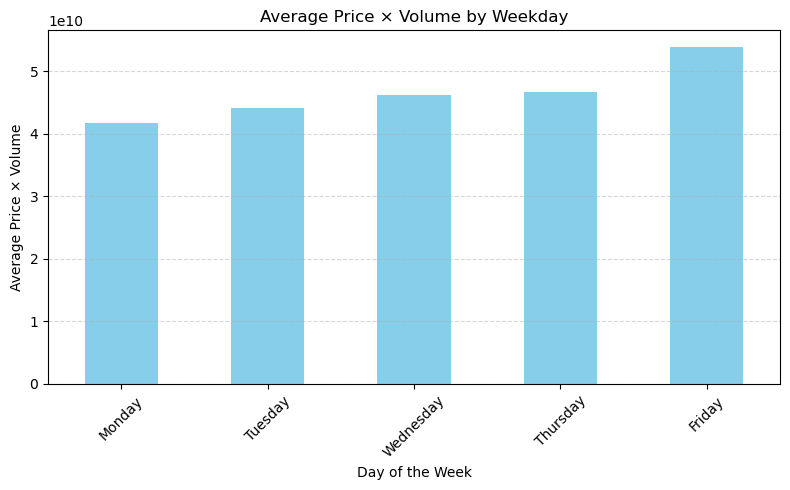

In [23]:
# Group by day_of_week and calculate average Price × Volume
avg_price_by_volume = df.groupby('day_of_week')['price by volume'].mean()

# Map day numbers to weekday names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
avg_price_by_volume.index = avg_price_by_volume.index.map(weekday_names)

# Plot
plt.figure(figsize=(8,5))
avg_price_by_volume.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price × Volume')
plt.title('Average Price × Volume by Weekday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

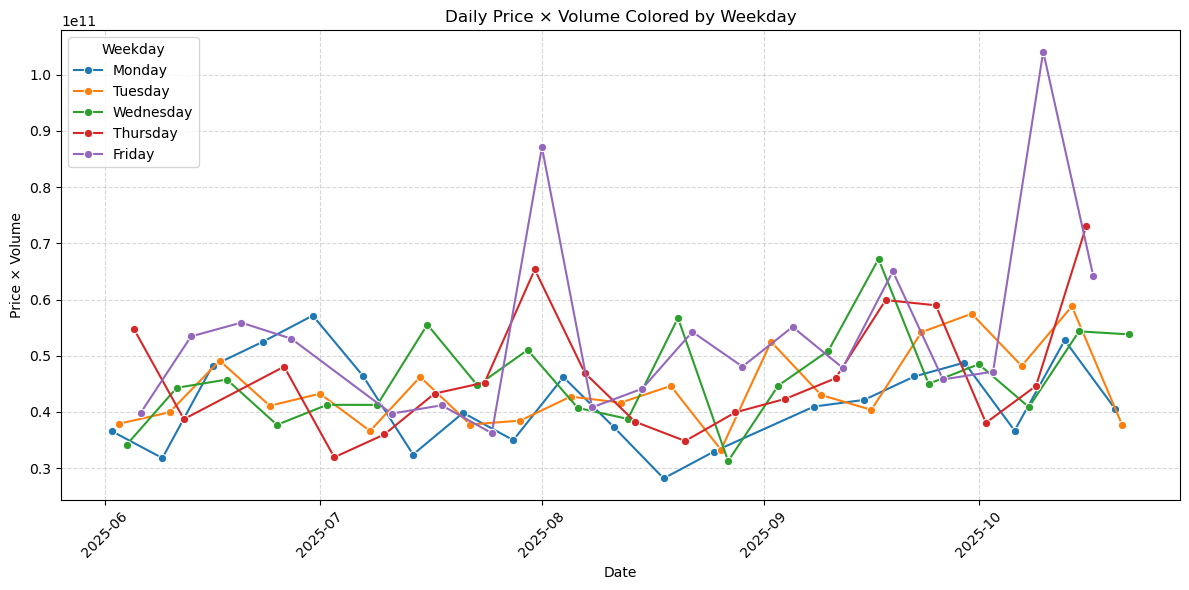

In [24]:
# Map numeric day_of_week to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
df['weekday_name'] = df['day_of_week'].map(weekday_names)

# Set a color palette for weekdays
palette = sns.color_palette("tab10", n_colors=5)  # 5 weekdays

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='price by volume', hue='weekday_name', palette=palette, marker='o')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Daily Price × Volume Colored by Weekday')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

In [25]:
#Average of close, volume by day of week
df.groupby('day_of_week')[['close', 'volume', 'price by volume']].mean()

,close,volume,price by volume
day_of_week,,,
0,636.167000,6.555691e+07,4.163893e+10
1,636.475714,6.915761e+07,4.404822e+10
2,637.734286,7.223458e+07,4.611915e+10
3,639.164211,7.296533e+07,4.664624e+10
4,637.006316,8.449561e+07,5.383842e+10


In [26]:
#Volatility by day of week
df.groupby('day_of_week')['log returns'].std()

day_of_week
0    0.005305
1    0.003825
2    0.005089
3    0.009863
4    0.006015
Name: log returns, dtype: float64

In [27]:
#Average daily return by day of week
df.groupby('day_of_week')['day to day'].mean()

day_of_week
0   -0.154000
1   -1.129048
2   -0.863750
3   -0.027895
4   -1.093158
Name: day to day, dtype: float64

In [28]:
#Which days have unusually high trading activity
threshold = df['volume'].mean() + df['volume'].std()
df[df['volume'] > threshold].groupby('day_of_week').size()

day_of_week
0    1
2    1
3    4
4    5
dtype: int64

In [29]:
#Correlation of pbv and daily by day of week
df.groupby('day_of_week')[['price by volume','day to day']].corr().iloc[0::2,-1]

day_of_week                 
0            price by volume    0.351567
1            price by volume   -0.060115
2            price by volume   -0.132386
3            price by volume    0.031574
4            price by volume   -0.548658
Name: day to day, dtype: float64

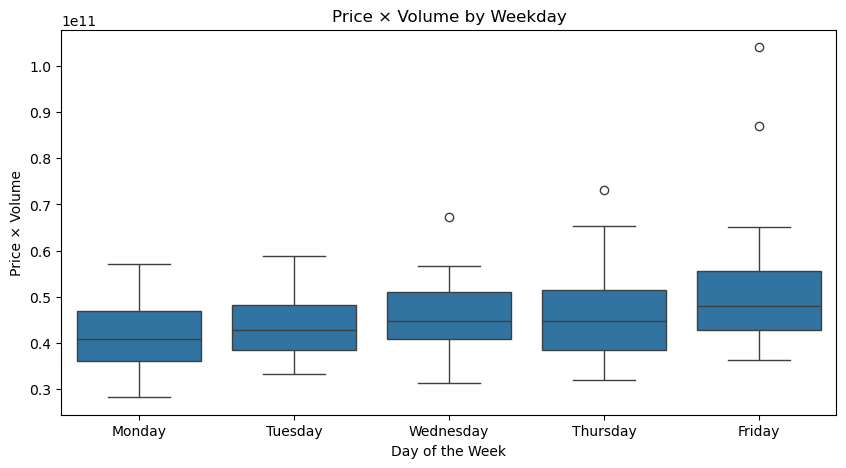

In [30]:
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Boxplot with correct weekday order
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday_name', y='price by volume', data=df, order=weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Price × Volume')
plt.title('Price × Volume by Weekday')
plt.show()

In [31]:
# Overall skewness
print("Skewness of Price × Volume:", df['price by volume'].skew())
if df['price by volume'].skew() > 0:
    print('Skewed Right')
if df['price by volume'].skew() < 0:
    print('Skewed Left')
if df['price by volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Volume:", df['volume'].skew())
if df['volume'].skew() > 0:
    print('Skewed Right')
if df['volume'].skew() < 0:
    print('Skewed Left')
if df['volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Close:", df['close'].skew())
if df['close'].skew() > 0:
    print('Skewed Right')
if df['close'].skew() < 0:
    print('Skewed Left')
if df['close'].skew() == 0:
    print('Roughly Symmetric')

Skewness of Price × Volume: 2.0222315368549366
Skewed Right
Skewness of Volume: 1.997345894275415
Skewed Right
Skewness of Close: -0.3032951092823837
Skewed Left


In [32]:
# Skewness of Price × Volume by day of week
skew_by_day = df.groupby('day_of_week')['price by volume'].skew()

# Map numeric day to names for readability
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
skew_by_day.index = skew_by_day.index.map(weekday_names)

# Interpret skewness for each day
for day, skew in skew_by_day.items():
    if skew > 0:
        interpretation = 'Skewed Right: Investors should be aware of potential for extreme gains'
    elif skew < 0:
        interpretation = 'Skewed Left: Could indicate risk of sharp losses or market inactivity'
    else:
        interpretation = 'Roughly Symmetric: Daily price changes or trading volume are more predictable'
    print(f"{day}: {skew:.2f} → {interpretation}")

# Print the skew values as well
print("\nSkewness values by day:")
print(skew_by_day)

Monday: 0.22 → Skewed Right: Investors should be aware of potential for extreme gains
Tuesday: 0.76 → Skewed Right: Investors should be aware of potential for extreme gains
Wednesday: 0.56 → Skewed Right: Investors should be aware of potential for extreme gains
Thursday: 0.99 → Skewed Right: Investors should be aware of potential for extreme gains
Friday: 1.90 → Skewed Right: Investors should be aware of potential for extreme gains

Skewness values by day:
day_of_week
Monday       0.217596
Tuesday      0.759245
Wednesday    0.561604
Thursday     0.987246
Friday       1.895958
Name: price by volume, dtype: float64


In [61]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with NaNs in essential columns
df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the OHLCV columns (exclude 'date')
scaled_features = scaler.fit_transform(df[['open', 'high', 'low', 'close', 'volume']])

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['open', 'high', 'low', 'close', 'volume'])

# Add the date column back
scaled_df['date'] = df['date'].values

# Optional: set date as index
scaled_df.set_index('date', inplace=True)

# Preview
print(scaled_df.head())

                open      high       low     close    volume
date                                                        
2025-06-02  0.000000  0.000000  0.000000  0.000000  0.154177
2025-06-03  0.053399  0.052859  0.079957  0.042040  0.171265
2025-06-04  0.107264  0.063578  0.122820  0.040050  0.116844
2025-06-05  0.115075  0.076516  0.070536  0.004229  0.420623
2025-06-06  0.127084  0.099064  0.138953  0.079975  0.197062
